# Plant Pathology 2021 - FGVC8
## Transfer Learning & Image augmentation using OpenCV
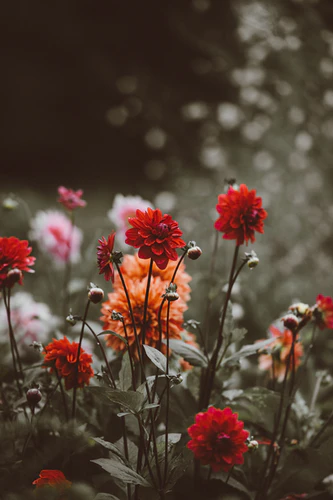
## Identify the category of foliar diseases in apple tree

### Problem Statement
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive. <br />

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc. <br />

Plant Pathology 2020-FGVC7 challenge competition had a pilot dataset of 3,651 RGB images of foliar disease of apples. For Plant Pathology 2021-FGVC8, we have significantly increased the number of foliar disease images and added additional disease categories. This year’s dataset contains approximately 23,000 high-quality RGB images of apple foliar diseases, including a large expert-annotated disease dataset. This dataset reflects real field scenarios by representing non-homogeneous backgrounds of leaf images taken at different maturity stages and at different times of day under different focal camera settings.
### Specific Objectives
The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image. <br />

# Table of Contents

1. Preparations
    1. Importing the necessary libraries
    2. Accelerator setup
    3. Importing the labels
    4. Exploring the data
2. Data
    1. Preprocessing the data
    2. Setting up image augmentation using OpenCV
3. CNN
    1. Picking the right pre-trained model
    2. Defining the Neural Network
    3. Training loop
    4. Save the model

# Preparations
## Importing the necessary libraries
#### We'll use pandas, numpy, random, and tensorflow, we'll import the rest later on

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf

## Accelerator setup
#### This cell is used to set up the TPU if you want to use it, I'd like to mention that I ran this notebook with a GPU and haven't tried TPU training yet.

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


## Importing the labels

In [ ]:
sample = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [ ]:
train.head(2)
train.labels.unique()

## Exploring the data
#### We'll use matplotlib to visualize a few images from the dataset.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import cv2

#### Read the images and organize them using subplots, then display them all at once

In [ ]:
im1 = cv2.imread('../input/plant-pathology-2021-fgvc8/train_images/800113bb65efe69e.jpg')
im2 = cv2.imread('../input/plant-pathology-2021-fgvc8/train_images/8002cb321f8bfcdf.jpg')
im3 = cv2.imread('../input/plant-pathology-2021-fgvc8/train_images/80070f7fb5e2ccaa.jpg')
im4 = cv2.imread('../input/plant-pathology-2021-fgvc8/train_images/800edef467d27c15.jpg')

In [ ]:
f, axes = plt.subplots(2,2)
axes[0][0].imshow(im1)
axes[0][1].imshow(im2)
axes[1][0].imshow(im3)
axes[1][1].imshow(im4)
plt.show()

In [ ]:
import os

# Data
## Preprocessing the Data
#### I used MultiLabelBinarizer in order to one-hot encode the multi-label outputs

In [ ]:
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv', index_col='image')

df['labels'] = [x.split(' ') for x in df['labels']]

binarizer = MultiLabelBinarizer()
labels = binarizer.fit_transform(df['labels'].values)

df = pd.DataFrame(
    index=df.index,
    columns=binarizer.classes_,
    data=labels)

In [ ]:
width, height = 400, 400

In [ ]:
from cv2 import imread, resize

In [ ]:
paths = ['../input/plant-pathology-2021-fgvc8/train_images/'+ path for path in os.listdir('../input/plant-pathology-2021-fgvc8/train_images')]

In [ ]:
labels = [df.loc[f'{name}'] for name in os.listdir('../input/plant-pathology-2021-fgvc8/train_images')]

In [ ]:
labels = np.array(labels)

## Setting up Image Augmentation using OpenCV
#### Out of every image, I decided to generate 5 more by rotating, and flipping the image

In [ ]:
from cv2 import getRotationMatrix2D, warpAffine, flip

In [ ]:
def rotateImage(image, range_s, range_e):
    range_random = random.randint(range_s, range_e)
    rm = getRotationMatrix2D((width/2,height/2), range_random, 1)
    rotated_image = warpAffine(image, rm, (width,height))
    
    range_random_2 = random.randint(range_s, range_e)
    rm = getRotationMatrix2D((width/2,height/2), range_random_2, 1)
    rotated_image_2 = warpAffine(image, rm, (width,height))
    rotated_image_2 = flip(rotated_image_2, 3)
    return rotated_image, rotated_image_2

In [ ]:
def augmentImages(imgpath):
    image = imread(imgpath)
    image = resize(image, (width,height)) #1
    
    image_rotated_1, image_rotated_2 = rotateImage(image, 10, 50) #2 - 3
    image_flipped = flip(image, 3) # 4
    image_flipped_rotated_1, image_flipped_rotated_2 = rotateImage(image_flipped, 10, 50) # 5 - 6
  #  cont = random.uniform(0.1, 1.5)* image  #7
  #  bright = image + random.randint(-10,10)#8
    batch = np.array([image, image_rotated_1, image_rotated_2, image_flipped, image_flipped_rotated_1,
                     image_flipped_rotated_2])
    return batch/255

In [ ]:
def showImages(dim1, dim2, imgs):
    gure, axes = plt.subplots(nrows=dim1, ncols=dim2, figsize=(20,15))
    for i in range(dim1*dim2):
        axes[i//dim2, i%dim2].imshow(np.array(imgs.pop()))

In [ ]:
batch = augmentImages('../input/plant-pathology-2021-fgvc8/train_images/800113bb65efe69e.jpg')

In [ ]:
showImages(2,3,list(batch))

# CNN
## Picking the right pre-trained model
#### The following info was taken from [Google AI Blog](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
#### Convolutional neural networks (CNNs) are commonly developed at a fixed resource cost, and then scaled up in order to achieve better accuracy when more resources are made available. For example, ResNet can be scaled up from ResNet-18 to ResNet-200 by increasing the number of layers, and recently, GPipe achieved 84.3% ImageNet top-1 accuracy by scaling up a baseline CNN by a factor of four. The conventional practice for model scaling is to arbitrarily increase the CNN depth or width, or to use larger input image resolution for training and evaluation. While these methods do improve accuracy, they usually require tedious manual tuning, and still often yield suboptimal performance. What if, instead, we could find a more principled method to scale up a CNN to obtain better accuracy and efficiency?
### EfficientNet Architecture
#### The effectiveness of model scaling also relies heavily on the baseline network. So, to further improve performance, we have also developed a new baseline network by performing a neural architecture search using the AutoML MNAS framework, which optimizes both accuracy and efficiency (FLOPS). The resulting architecture uses mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but is slightly larger due to an increased FLOP budget. We then scale up the baseline network to obtain a family of models, called EfficientNets.
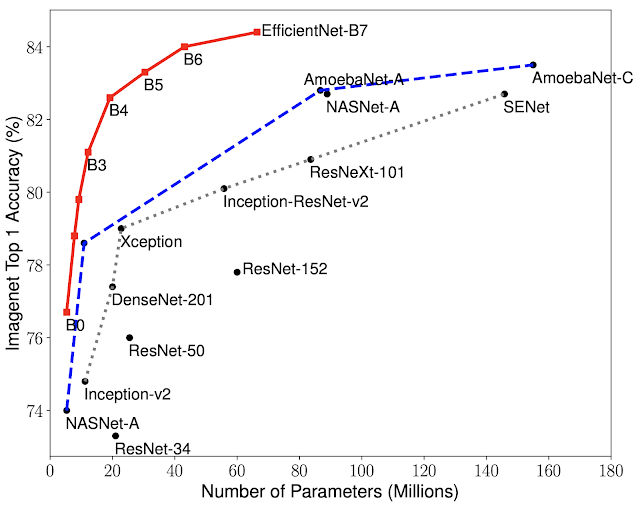
### EfficientNet Performance
#### We have compared our EfficientNets with other existing CNNs on ImageNet. In general, the EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs, reducing parameter size and FLOPS by an order of magnitude. For example, in the high-accuracy regime, our EfficientNet-B7 reaches state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on CPU inference than the previous Gpipe. Compared with the widely used ResNet-50, our EfficientNet-B4 uses similar FLOPS, while improving the top-1 accuracy from 76.3% of ResNet-50 to 82.6% (+6.3%).
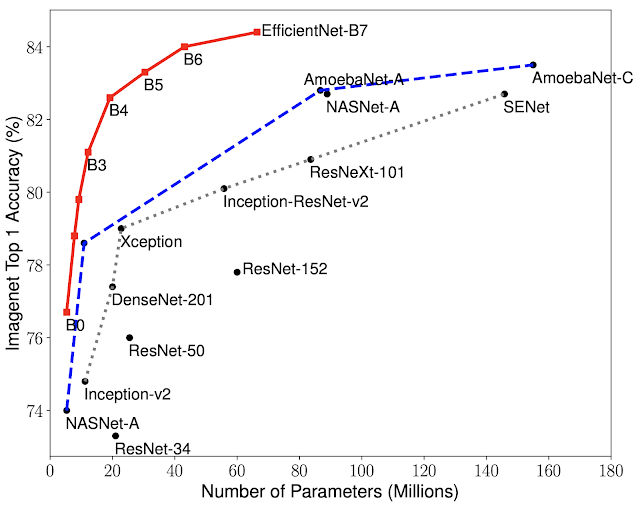
Model Size vs. Accuracy Comparison. EfficientNet-B0 is the baseline network developed by AutoML MNAS, while Efficient-B1 to B7 are obtained by scaling up the baseline network. In particular, our EfficientNet-B7 achieves new state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy, while being 8.4x smaller than the best existing CNN. For more info read [here](https://arxiv.org/abs/1905.11946)
### After doing a bit of research, I decided that **EfficientNet** would be the ideal set of pre-trained models that I can play around with, due to it's high performance and low relative computational cost.


## Defining the Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, GlobalMaxPooling2D, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
with strategy.scope():
    Input_tensor = Input((width,height,3))

    en = EfficientNetB0(include_top = False, input_tensor = Input_tensor)
    en.trainable = False

    model = Sequential()
    model.add(en)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))


    model.add(Dense(2048, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(2048, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(2048, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(2048, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1024, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(7, activation = 'sigmoid'))


    optimizer = Adam(0.0001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model.summary()

## Training Loop
#### Since the data can't fit in the RAM, I had to define a custom generator and train the CNN batch by batch.

In [ ]:
from tqdm import tqdm

In [ ]:
n_samples = len(paths)
n_samples

In [ ]:
epochs = 1

In [ ]:
from IPython.display import clear_output

In [ ]:
import gc

In [ ]:
losses = []
accs = []
cnt = 0
for label in tqdm(labels):
    
    one_img_augmented_6 = augmentImages(paths.pop())
    
    for epoch in range(epochs):
        loss, acc = model.train_on_batch(one_img_augmented_6, np.array([label,label,label,label,label,label]))
        
        del one_img_augmented_6
        losses.append(loss)
        accs.append(acc)
        cnt+=1
        
    gc.collect()
    
    if cnt>=10000:
        cnt = 0
        clear_output()
        print(acc)
        plt.figure(figsize = (16,16))
        plt.plot(accs)
        plt.plot(losses)
        plt.legend(['accs', 'losses'])
        plt.show()
        del loss, acc
    

## Saving the model
#### Always remember to save your model! so you can use it later in inference or further training.

In [ ]:
model.save('model.h5py')

# End
Thank you for reading, if this helped you, or you learnt something new from it, give it an upvote!